In [ ]:
pip install bruges

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 3.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import tensorflow as tf
import numpy              as np
import matplotlib.pyplot  as plt
import scipy
from scipy import signal
import bruges.filters.wavelets as w
import os
plt.rcParams.update({'font.size': 28})

In [ ]:
# generate random trace with length dz
def trace_gen(dz):
    # init
    y_train = np.zeros(dz); X_train = np.zeros(dz)
    # generate random wavelet [duration in s, freq, time series to be eval]
    wave, _ = w.ricker(1, 0.0008, 20)
    # compute maximum phase
    a=np.where(np.abs(wave)>1e-4)[0][0]
    # number of random reflection coefficients in the time series np.random.randint[start_value, end_value , amount of samples]
    rand_lay = np.random.randint(1, 8)
    # depth of random horizon [max dz-50]
    idx = np.random.randint(1, dz-1, rand_lay)
    # idx_val random, varying between [-1, 1] -> np.random.rand default [0,1]
    idx_val = (np.random.rand(rand_lay)-0.5) * 2
    # insert at idx pos idx_val reflection coefficient spike
    X_train[idx] = idx_val
    # convolve trace and wave
    y_train = signal.convolve(X_train, wave)[a:dz+a]
    # generate y_train at maximum phase (a is the shift)
    return X_train, y_train


In [ ]:
n_it = 1000       # number of traces
dz = 1024         # number of samples in depth/time

In [ ]:
# Define empty arrays to be filled with the function
X_train = np.zeros((n_it, dz, 1))
y_train = np.zeros((n_it, dz, 1))

import time
start = time.time()
for i in range(n_it):
    X_train[i, :, 0], y_train[i, :, 0] = trace_gen(dz)

end = time.time()
print((end - start)*1000)

517.7962779998779


In [ ]:
wave, _ = w.ricker(1, 0.0008, 20)
# compute maximum phase
a=np.where(np.max(wave)==wave)[0][0]

In [ ]:
a

625

In [ ]:
# Define empty arrays to be filled with the function
y_train_max = np.zeros((n_it, dz, 1))

import time
start = time.time()
for i in range(n_it):
    y_train_max[i, :, 0] = signal.convolve(X_train[i, :, 0], wave)[a:dz+a]


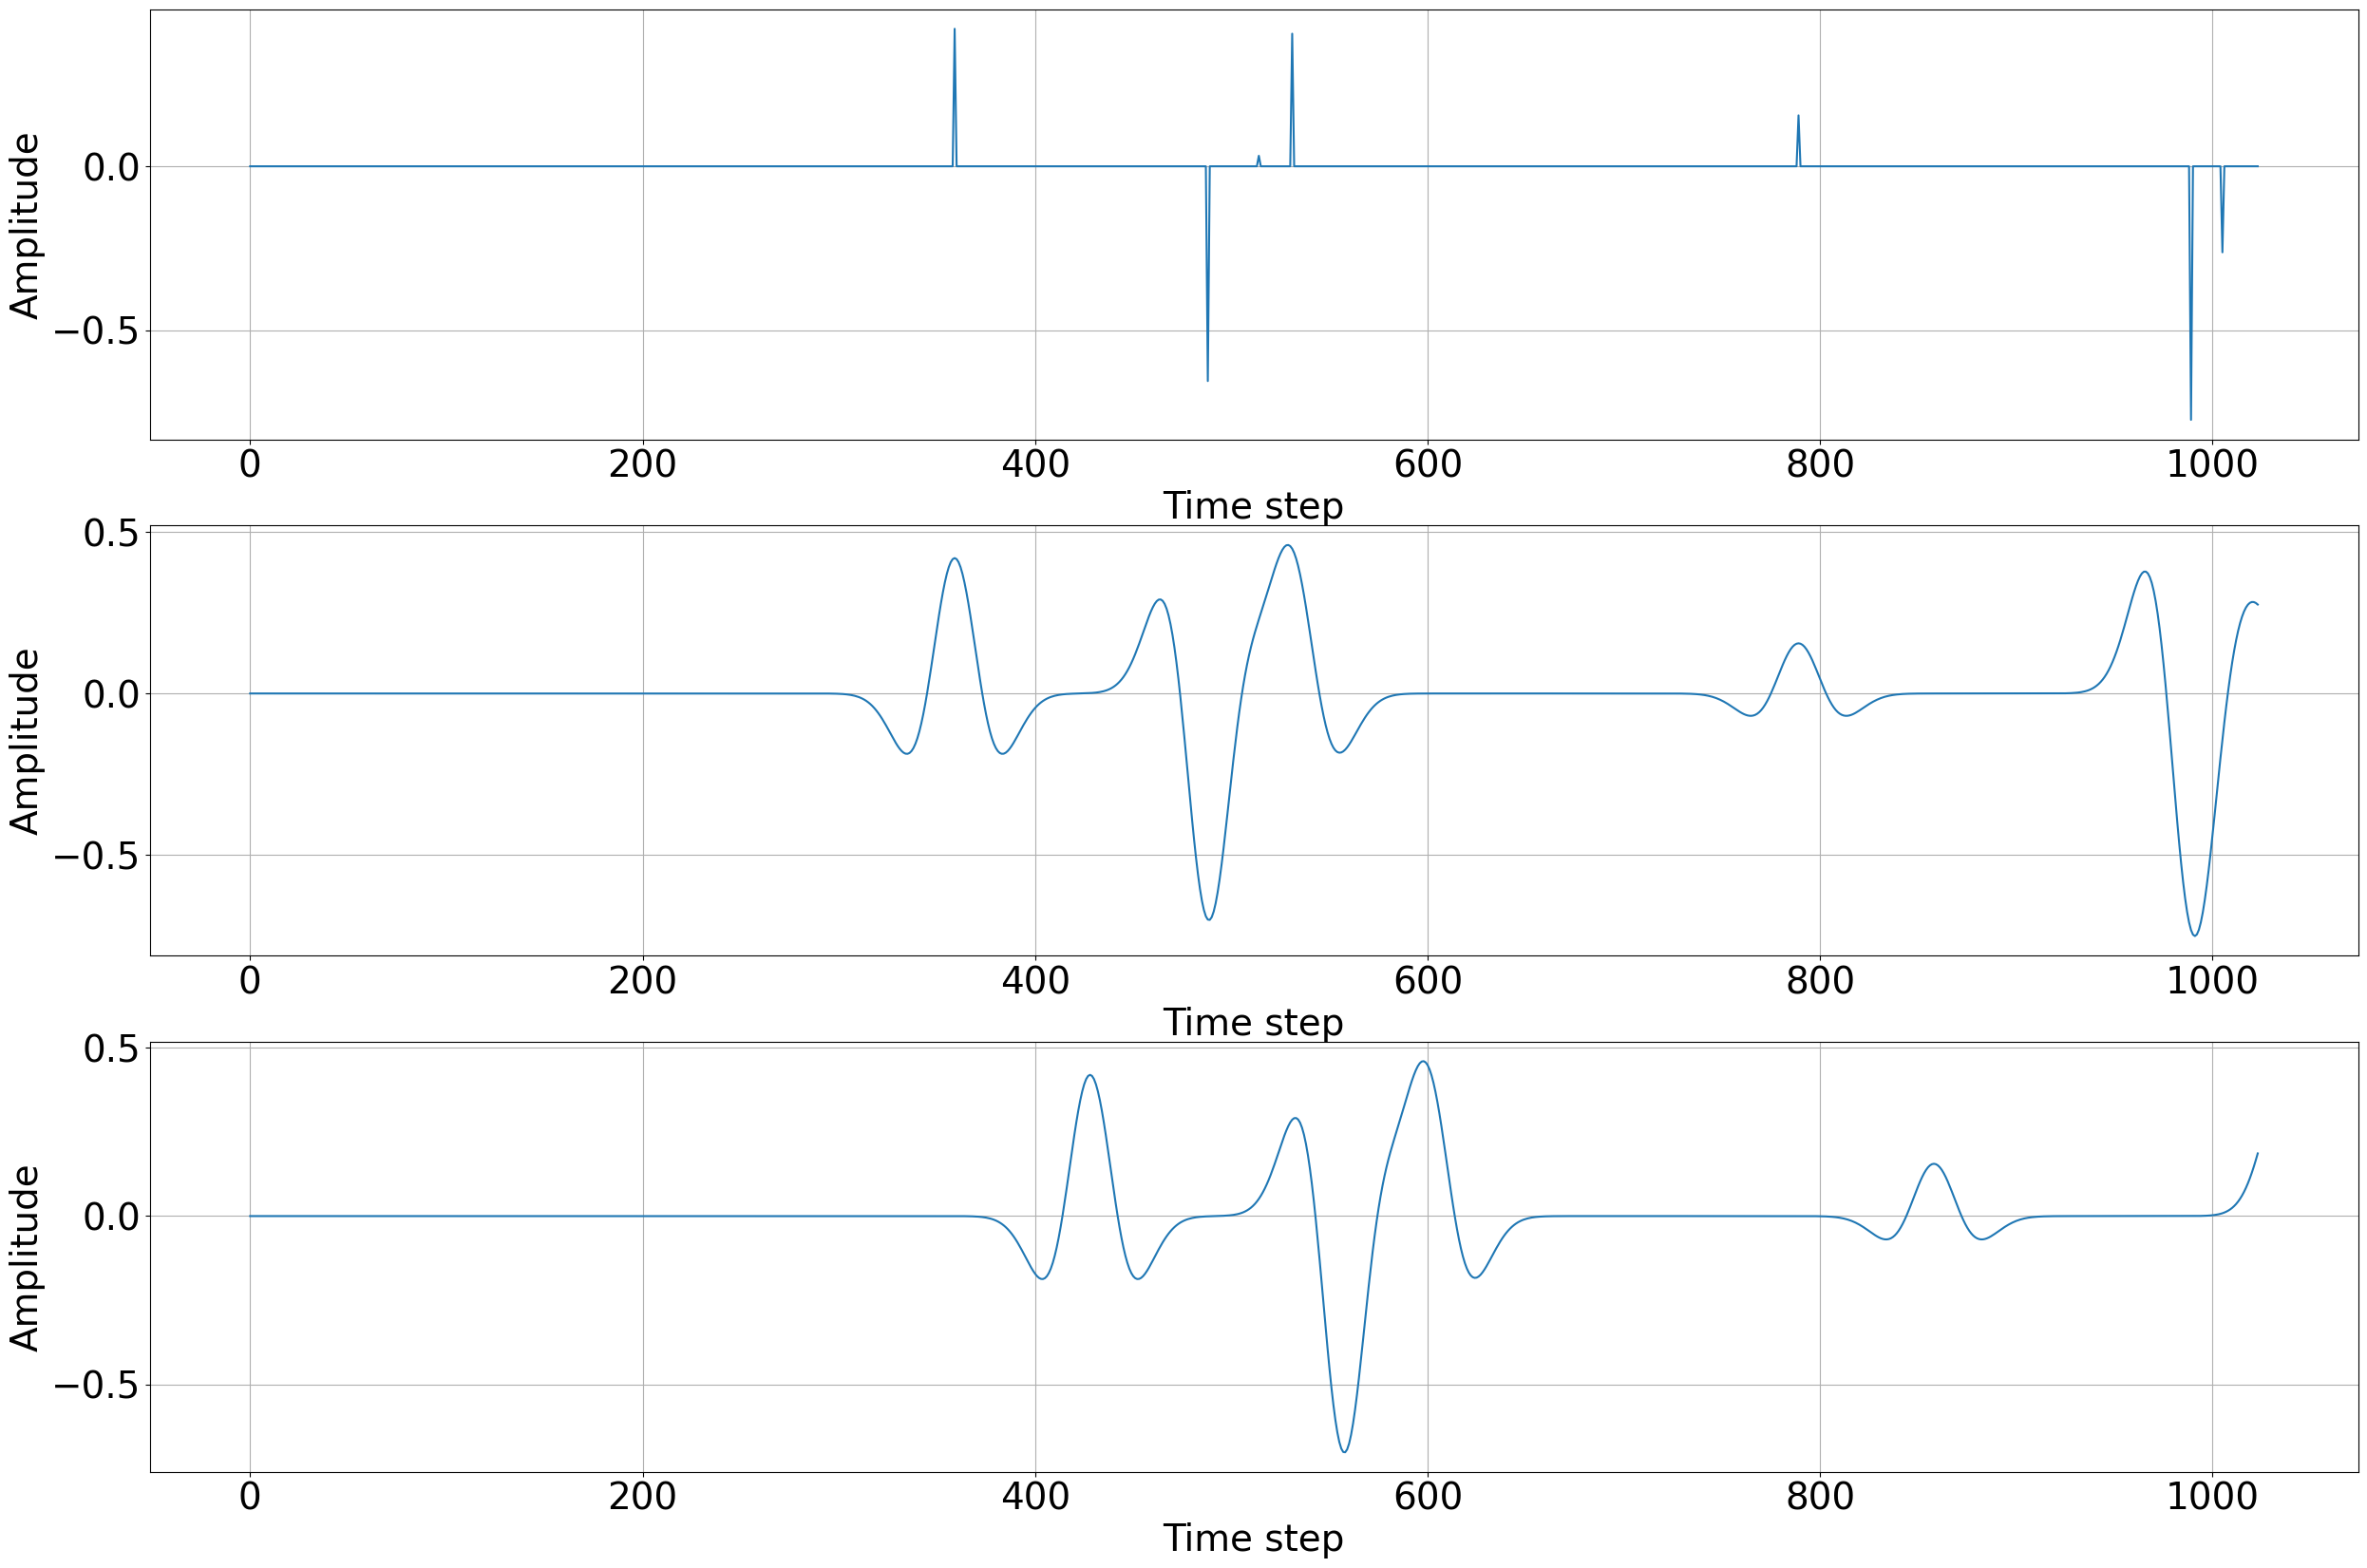

In [ ]:
i = 8

plt.figure(figsize=[30, 20])
plt.subplot(311)
plt.plot(X_train [i, :, 0])
plt.grid(True)
plt.xlabel('Time step')
plt.ylabel('Amplitude')

plt.subplot(312)
plt.plot(y_train_max[i, :, 0])
plt.grid(True)
plt.xlabel('Time step')
plt.ylabel('Amplitude')

plt.subplot(313)
plt.plot(y_train [i, :, 0])
plt.grid(True)
plt.xlabel('Time step')
plt.ylabel('Amplitude')
plt.savefig('AC_0', dpi =200)

In [ ]:

# define Bi-Directional LSTM
inputs = tf.keras.Input(shape=(1024, 1))
forward_layer = tf.keras.layers.LSTM(4, return_sequences=True)
backward_layer = tf.keras.layers.LSTM(4, return_sequences=True, go_backwards=True)
v = tf.keras.layers.Bidirectional(forward_layer, backward_layer=backward_layer)(inputs)

forward_layer = tf.keras.layers.LSTM(2, return_sequences=True)
backward_layer = tf.keras.layers.LSTM(2, return_sequences=True, go_backwards=True)
v = tf.keras.layers.Bidirectional(forward_layer, backward_layer=backward_layer)(v)

forward_layer = tf.keras.layers.LSTM(1, return_sequences=True)
backward_layer = tf.keras.layers.LSTM(1, return_sequences=True, go_backwards=True)
v = tf.keras.layers.Bidirectional(forward_layer, backward_layer=backward_layer)(v)

v = tf.keras.layers.LSTM(1, return_sequences= True)(v)
model = tf.keras.Model(inputs=[inputs], outputs=[v])

model.summary()

# Compile NN
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.01), loss = 'mse')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024, 1)]         0         
                                                                 
 bidirectional (Bidirection  (None, 1024, 8)           192       
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 1024, 4)           176       
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 1024, 2)           48        
 onal)                                                           
                                                                 
 lstm_6 (LSTM)               (None, 1024, 1)           16        
                                                             

In [ ]:
# define Bi-Directional LSTM
inputs = tf.keras.Input(shape=(1024, 1))

v = tf.keras.layers.LSTM(8, return_sequences=True)(inputs)
v = tf.keras.layers.LSTM(4, return_sequences=True)(v)
v = tf.keras.layers.LSTM(2, return_sequences=True)(v)
v = tf.keras.layers.LSTM(1, return_sequences= True)(v)
model_nobid = tf.keras.Model(inputs=[inputs], outputs=[v])

model_nobid.summary()

# Compile NN
model_nobid.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.01), loss = 'mse')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1024, 1)]         0         
                                                                 
 lstm_7 (LSTM)               (None, 1024, 8)           320       
                                                                 
 lstm_8 (LSTM)               (None, 1024, 4)           208       
                                                                 
 lstm_9 (LSTM)               (None, 1024, 2)           56        
                                                                 
 lstm_10 (LSTM)              (None, 1024, 1)           16        
                                                                 
Total params: 600 (2.34 KB)
Trainable params: 600 (2.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs = 300, batch_size = 128, verbose=1)

Epoch 1/300
8/8 [==============================] - 18s 159ms/step - loss: 0.0239
Epoch 2/300
8/8 [==============================] - 1s 143ms/step - loss: 0.0238
Epoch 3/300
8/8 [==============================] - 1s 141ms/step - loss: 0.0238
Epoch 4/300
8/8 [==============================] - 1s 143ms/step - loss: 0.0238
Epoch 5/300
8/8 [==============================] - 1s 141ms/step - loss: 0.0238
Epoch 6/300
8/8 [==============================] - 1s 141ms/step - loss: 0.0238
Epoch 7/300
8/8 [==============================] - 1s 137ms/step - loss: 0.0238
Epoch 8/300
8/8 [==============================] - 2s 225ms/step - loss: 0.0238
Epoch 9/300
8/8 [==============================] - 2s 193ms/step - loss: 0.0238
Epoch 10/300
8/8 [==============================] - 1s 142ms/step - loss: 0.0238
Epoch 11/300
8/8 [==============================] - 1s 144ms/step - loss: 0.0238
Epoch 12/300
8/8 [==============================] - 1s 145ms/step - loss: 0.0238
Epoch 13/300
8/8 [==================

In [ ]:
history_nobid = model_nobid.fit(X_train, y_train, epochs = 300, batch_size = 128, verbose=1)

Epoch 1/300
8/8 [==============================] - 7s 99ms/step - loss: 0.0297
Epoch 2/300
8/8 [==============================] - 1s 82ms/step - loss: 0.0246
Epoch 3/300
8/8 [==============================] - 1s 85ms/step - loss: 0.0239
Epoch 4/300
8/8 [==============================] - 1s 86ms/step - loss: 0.0239
Epoch 5/300
8/8 [==============================] - 1s 86ms/step - loss: 0.0238
Epoch 6/300
8/8 [==============================] - 1s 83ms/step - loss: 0.0238
Epoch 7/300
8/8 [==============================] - 1s 81ms/step - loss: 0.0237
Epoch 8/300
8/8 [==============================] - 1s 85ms/step - loss: 0.0237
Epoch 9/300
8/8 [==============================] - 1s 124ms/step - loss: 0.0237
Epoch 10/300
8/8 [==============================] - 1s 131ms/step - loss: 0.0237
Epoch 11/300
8/8 [==============================] - 1s 96ms/step - loss: 0.0237
Epoch 12/300
8/8 [==============================] - 1s 84ms/step - loss: 0.0237
Epoch 13/300
8/8 [=============================

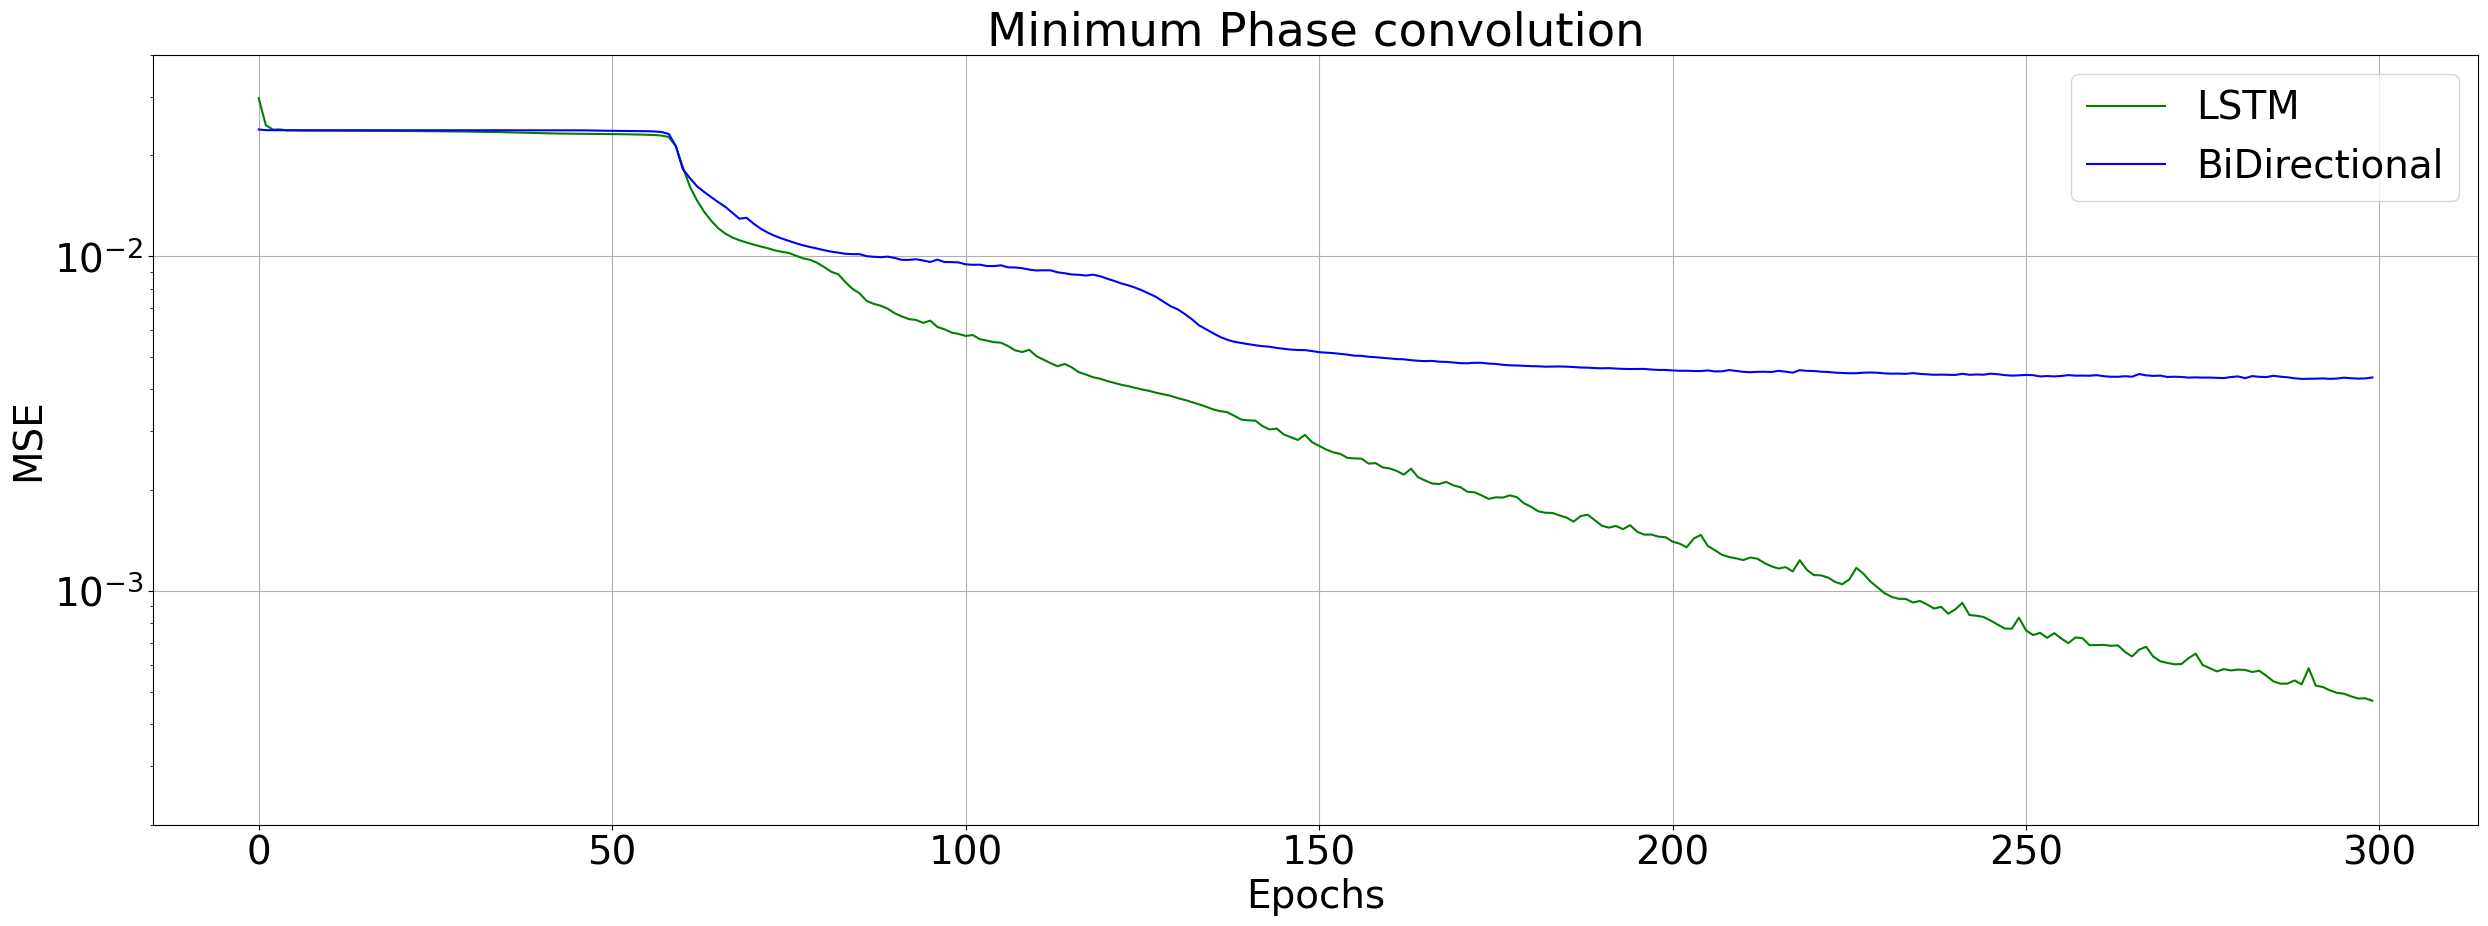

In [ ]:
plt.figure(figsize=[30, 10])
plt.semilogy(history_nobid.history['loss'], label = 'LSTM', color = 'g')
plt.semilogy(history.history['loss'], label = 'BiDirectional', color = 'b')
plt.legend()
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Minimum Phase convolution')
plt.ylim([2e-4, 4e-2])
plt.savefig('AB_1', dpi =200)


In [ ]:
start = time.time()
y_pred_nobid = model_nobid.predict(X_train, verbose = 0, batch_size = 1024)
end = time.time()
print((end - start)*1000)
y_pred       = model.predict(X_train, verbose = 0, batch_size = 1024)
end = time.time()
print((end - start)*1000)

1857.7523231506348
4515.68603515625


In [ ]:
X_train.shape

(1000, 1024, 1)

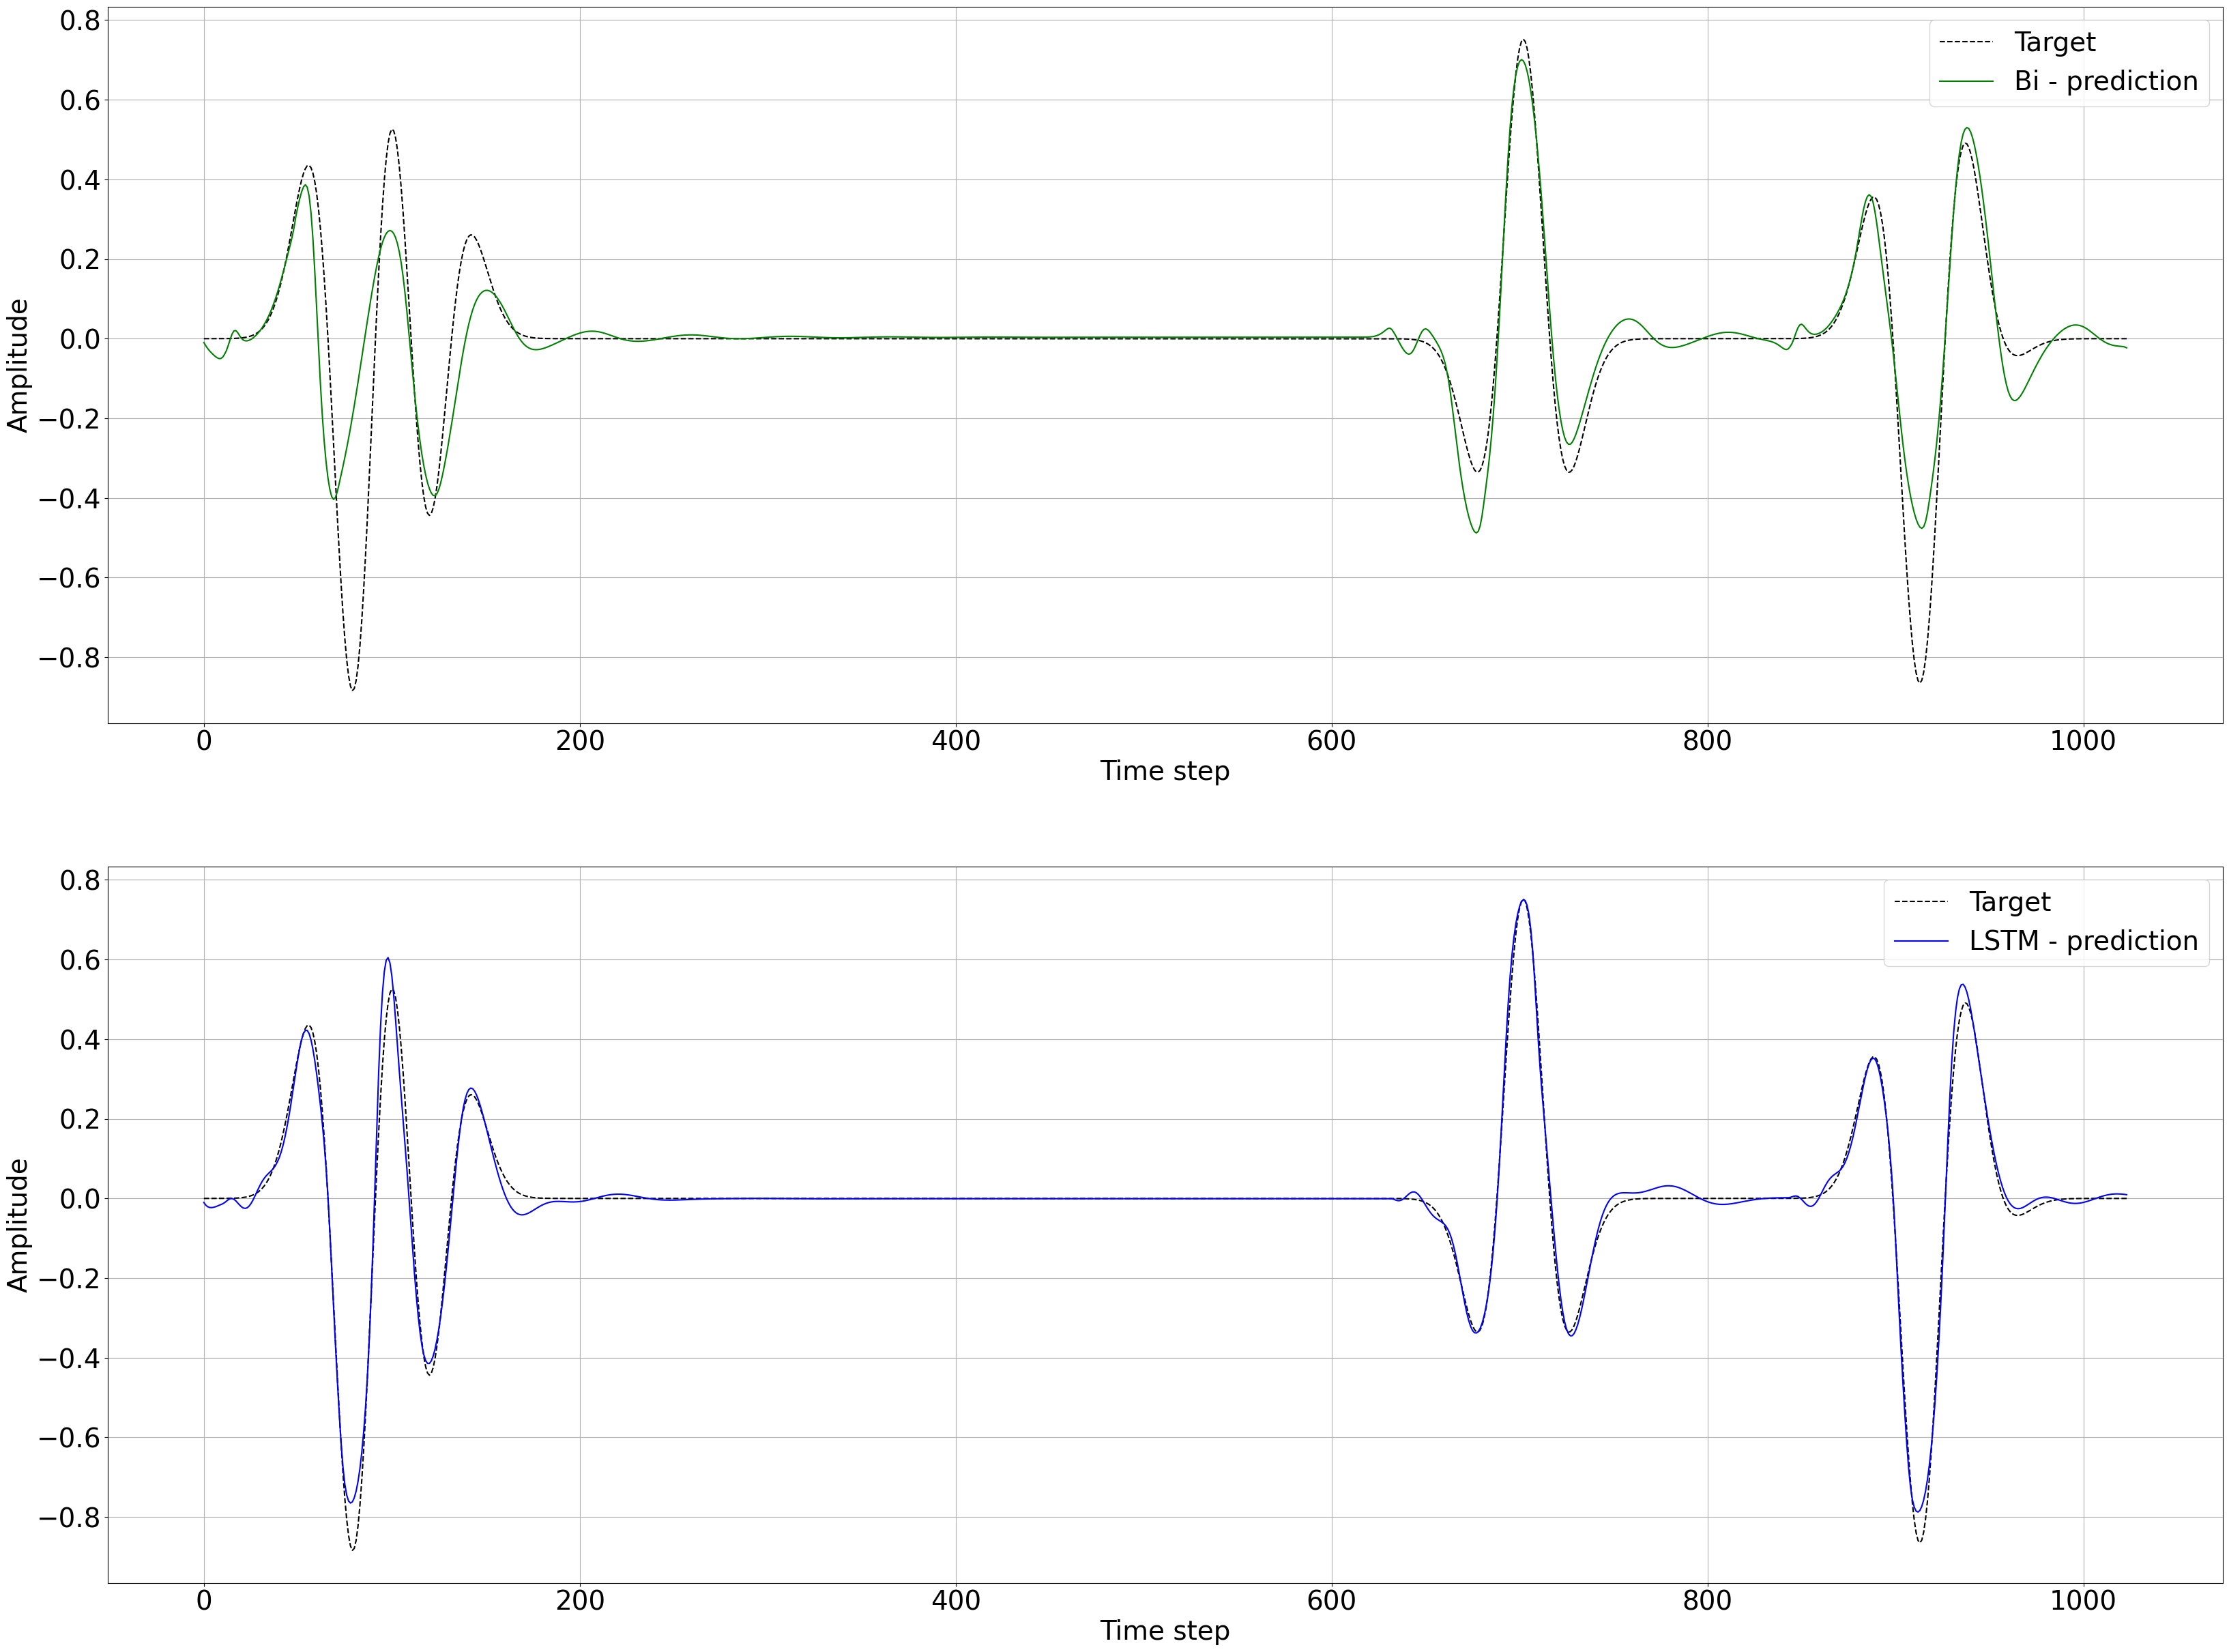

In [ ]:
i = 4

plt.figure(figsize=[40, 30])
plt.subplot(211)

plt.plot(y_train [i, :, 0], "--", label = 'Target', color = 'k')
plt.plot(y_pred [i, :, 0], label = 'Bi - prediction', color = 'g')
plt.grid(True)
plt.legend()
plt.xlabel('Time step')
plt.ylabel('Amplitude')

plt.subplot(212)
plt.plot(y_train [i, :, 0], "--", label = 'Target', color = 'k')
plt.plot(y_pred_nobid [i, :, 0], label = 'LSTM - prediction', color = 'b')
plt.grid(True)
plt.legend()
plt.xlabel('Time step')
plt.ylabel('Amplitude')
plt.savefig('AB_2', dpi =200)
